In [1]:
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer,IndexToString, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import collect_set, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
from pyspark.sql.functions import split, slice, size, concat_ws, when
from pyspark.ml.feature import Imputer
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('Spark-Group1-Flights-EDA').getOrCreate()

In [3]:
# load dataset
gcs_path = "gs://msca-bdp-student-gcs/Group1/newdata.parquet/"

# Read the CSV file from GCS
df = spark.read.parquet(gcs_path, header=True, inferSchema=True)
df.show(10)

+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+----------------+----------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|isNonStop|totalFare|seatsRemaining|DaysBeforeFlight|  Layovers|NumStops|        AirlineNames|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|
+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+----------------+----------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|ec53549db1796bc5b...|2022-09-22|2022-11-06|            SFO|    

In [4]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: integer (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isRefundable: integer (nullable = true)
 |-- isNonStop: integer (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- DaysBeforeFlight: integer (nullable = true)
 |-- Layovers: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NumStops: integer (nullable = true)
 |-- AirlineNames: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NumUniqueAirlines: integer (nullable = true)
 |-- AircraftType: integer (nullable = true)
 |-- NumUniqueCabins: integer (nullable = true)
 |-- hasFirstClass: integer (nullable = true)
 |-- FlightArrivalDate: date (nullable = true)
 |-- totalT

In [ ]:
# repartition
num = df.rdd.getNumPartitions()
print(num)
df = df.repartition(num)

39


# GBT MODEL

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import log

In [26]:
# Train data
train_path = "gs://msca-bdp-student-gcs/Group1/lr_data/traindata_transformed/"
df_train = spark.read.parquet(train_path, header=True, inferSchema=True)

df_train.show(10)

+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------------+---------------+-------------+-----------------+-------------------+----------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|               legId|searchDate|flightDate|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|startingAirport_onehot|destinationAirport_onehot|AirlineName_0_onehot|AirlineName_1_onehot|AirlineName_2_onehot|AirlineName_3_onehot|AirlineName_4_onehot|    log_totalFare|
+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------

In [27]:
# test data
test_path = "gs://msca-bdp-student-gcs/Group1/lr_data/testdata_transformed/"
df_test = spark.read.parquet(train_path, header=True, inferSchema=True)

df_test.show(10)

+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------------+---------------+-------------+-----------------+-------------------+----------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|               legId|searchDate|flightDate|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|startingAirport_onehot|destinationAirport_onehot|AirlineName_0_onehot|AirlineName_1_onehot|AirlineName_2_onehot|AirlineName_3_onehot|AirlineName_4_onehot|    log_totalFare|
+--------------------+----------+----------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+-----------------+------

## Benchmark Model

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Benchmark model
feature_columns = [
    "travelDuration", "elapsedDays", "isRefundable", "seatsRemaining", 
    "DaysBeforeFlight", "NumStops", "NumUniqueAirlines", "AircraftType", 
    "NumUniqueCabins", "hasFirstClass", "totalTravelDistance",
    "startingAirport_onehot", "destinationAirport_onehot", 
    "AirlineName_0_onehot", "AirlineName_1_onehot", "AirlineName_2_onehot", 
    "AirlineName_3_onehot", "AirlineName_4_onehot"
]

# features into vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)

# Target variable
df_train = df_train.withColumnRenamed("log_totalFare", "label")
df_test = df_test.withColumnRenamed("log_totalFare", "label")

In [ ]:
# define GBT model
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5)
gbt_model = gbt.fit(df_train)

# predict on test data
predictions = gbt_model.transform(df_test)

# model evaluation
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"GBT Benchmark Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

GBT Benchmark Model Performance:
Root Mean Squared Error (RMSE): 0.3692919649060789
R-squared (R²): 0.5920571146006594


## Feature Importance

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType

feature_importances = gbt_model.featureImportances.toArray()

# Feature importances
importance_data = [(feature_columns[i], float(feature_importances[i])) for i in range(len(feature_columns))]

# Create a PySpark DataFrame
spark = SparkSession.builder.getOrCreate()
schema = StructType([
    StructField("Feature", StringType(), True),
    StructField("Importance", FloatType(), True)
])
importance_df = spark.createDataFrame(importance_data, schema)

# Sort the importance DataFrame by 'Importance' in descending order
importance_ranked_df = importance_df.orderBy("Importance", ascending=False)

from pyspark.sql.functions import rank
from pyspark.sql.window import Window

# Define a window specification for ranking
window_spec = Window.orderBy(importance_ranked_df["Importance"].desc())
importance_ranked_df = importance_ranked_df.withColumn("Rank", rank().over(window_spec))
importance_ranked_df.show(truncate=False)

24/12/03 03:24:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 03:24:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 03:24:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 03:24:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/03 03:24:43 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

+-------------------------+------------+----+
|Feature                  |Importance  |Rank|
+-------------------------+------------+----+
|totalTravelDistance      |0.1973288   |1   |
|travelDuration           |0.099217504 |2   |
|seatsRemaining           |0.06987792  |3   |
|NumUniqueAirlines        |0.0690371   |4   |
|DaysBeforeFlight         |0.04918615  |5   |
|hasFirstClass            |0.023707151 |6   |
|AirlineName_0_onehot     |0.019429704 |7   |
|destinationAirport_onehot|0.014678557 |8   |
|AirlineName_3_onehot     |0.0099891145|9   |
|startingAirport_onehot   |0.009672513 |10  |
|AirlineName_2_onehot     |0.008560828 |11  |
|AircraftType             |0.00854629  |12  |
|AirlineName_4_onehot     |0.0066447747|13  |
|NumUniqueCabins          |0.006232057 |14  |
|NumStops                 |0.006142347 |15  |
|elapsedDays              |0.0055798185|16  |
|AirlineName_1_onehot     |0.0036835736|17  |
|isRefundable             |0.0         |18  |
+-------------------------+-------

## Model after feature selection

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Model using features after removing non important features
selected_features = [
    "totalTravelDistance", "travelDuration", "seatsRemaining", "NumUniqueAirlines",
    "DaysBeforeFlight", "hasFirstClass", "AirlineName_0_onehot", 
    "destinationAirport_onehot", "AirlineName_3_onehot", "startingAirport_onehot"
]

assembler = VectorAssembler(inputCols=selected_features, outputCol="new_features")

# Delete existing features
df_train = df_train.drop("features")
df_test = df_test.drop("features")

df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)
df_train = df_train.withColumnRenamed("log_totalFare", "label")
df_test = df_test.withColumnRenamed("log_totalFare", "label")

In [ ]:
# GBT after removing the non important features
gbt = GBTRegressor(featuresCol="new_features", labelCol="label", maxIter=100, maxDepth=5)
gbt_model = gbt.fit(df_train)
predictions = gbt_model.transform(df_test)

# Evaluation
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"GBT Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

GBT Model Performance:
Root Mean Squared Error (RMSE): 0.3713836401317853
R-squared (R²): 0.5874228381204167


We used feature importance for feature selection resulted in worse model performance may because:
1. Loss of feature interactions: Some features with low importance may still have critical interactions with other features, contributing to the model's overall predictive power.
2. Value of redundant information: Low-importance features might provide redundant information that helps the model better generalize or stabilize predictions.
3. GBT's robustness to noise: GBT is inherently robust to irrelevant or noisy features. Removing features can reduce model complexity but may also lead to underfitting.
As a result, the slight drop in R^2 and increase in RMSE indicates that the information loss from removing these features outweighed the benefits of simplification.

## Find best parameters

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

selected_features = [
    "travelDuration", "elapsedDays", "seatsRemaining", 
    "DaysBeforeFlight", "NumStops", "NumUniqueAirlines", "AircraftType", 
    "NumUniqueCabins", "hasFirstClass", "totalTravelDistance",
    "startingAirport_onehot", "destinationAirport_onehot", 
    "AirlineName_0_onehot", "AirlineName_2_onehot", 
    "AirlineName_3_onehot", "AirlineName_4_onehot"
]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)

df_train = df_train.withColumnRenamed("log_totalFare", "label")
df_test = df_test.withColumnRenamed("log_totalFare", "label")

# Define the model
gbt = GBTRegressor(featuresCol="features", labelCol="label")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [50, 100]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Define TrainValidationSplit
tvs = TrainValidationSplit(estimator=gbt, 
                           estimatorParamMaps=paramGrid, 
                           evaluator=evaluator, 
                           trainRatio=0.8) 

tvs_model = tvs.fit(df_train)

# Get the best model with best parameters
best_model = tvs_model.bestModel

# Test the model on test model
predictions = best_model.transform(df_test)
rmse = evaluator.evaluate(predictions)
print(f"Optimized RMSE: {rmse}")

24/12/03 21:09:38 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/03 21:56:46 WARN org.apache.spark.storage.BlockManager: Asked to remove block broadcast_1950, which does not exist


## Final model after tuning the hyperparameters

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Redefine the GBT using tuning parameters
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5)

gbt_model = gbt.fit(train_data)
predictions = gbt_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Gradient Boosting Performance:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

### Time Series Model

In [ ]:
import pandas as pd

In [ ]:
# Group by flightDate and calculate the average fare
df_time_series = (
    df.groupBy("flightDate")
    .avg("totalFare")
    .withColumnRenamed("avg(totalFare)", "totalFare")
    .orderBy("flightDate")
)

# Convert flightDate to Pandas Datetime format
df_time_series_pandas = df_time_series.toPandas()
df_time_series_pandas["flightDate"] = pd.to_datetime(df_time_series_pandas["flightDate"])

# Set flightDate as the index
df_time_series_pandas.set_index("flightDate", inplace=True)

# Time series dataframe
print(df_time_series_pandas.head())

In [13]:
from statsmodels.tsa.stattools import adfuller

# Check whether stationary
result = adfuller(df_time_series_pandas['totalFare'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Stationary" if result[1] < 0.05 else "Non-stationary")

ADF Statistic: -0.9903848697053408
p-value: 0.7567550244501254
Non-stationary


## Use first-order differencing

In [ ]:
df_time_series_pandas['totalFare_diff'] = df_time_series_pandas['totalFare'].diff().dropna()

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_time_series_pandas['totalFare_diff1'].dropna())
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Data is stationary after differencing")

p-value: 1.7997720208983093e-05
Data is stationary after differencing


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(df_time_series_pandas['totalFare'], label="Original Time Series")
plt.title("Original Total Fare Time Series")
plt.legend()
plt.show()

In [ ]:
df_time_series_pandas['totalFare_diff'] = df_time_series_pandas['totalFare'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(df_time_series_pandas['totalFare_diff'], label="Differenced Time Series")
plt.title("Differenced Total Fare Time Series")
plt.legend()
plt.show()

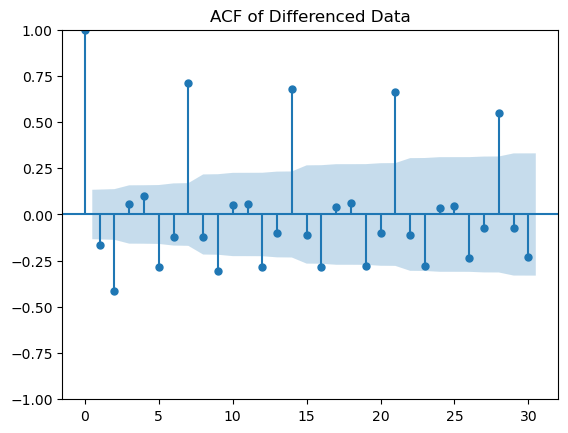

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


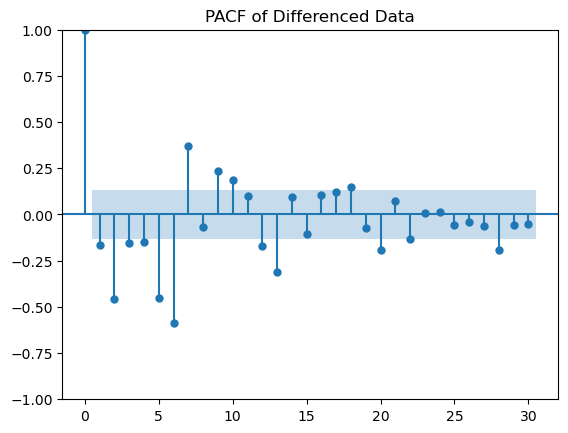

In [36]:
# ACF and PACF chart to select p and q
plot_acf(df_time_series_pandas['totalFare_diff'].dropna(), lags=30)
plt.title("ACF of Differenced Data")
plt.show()

plot_pacf(df_time_series_pandas['totalFare_diff'].dropna(), lags=30)
plt.title("PACF of Differenced Data")
plt.show()

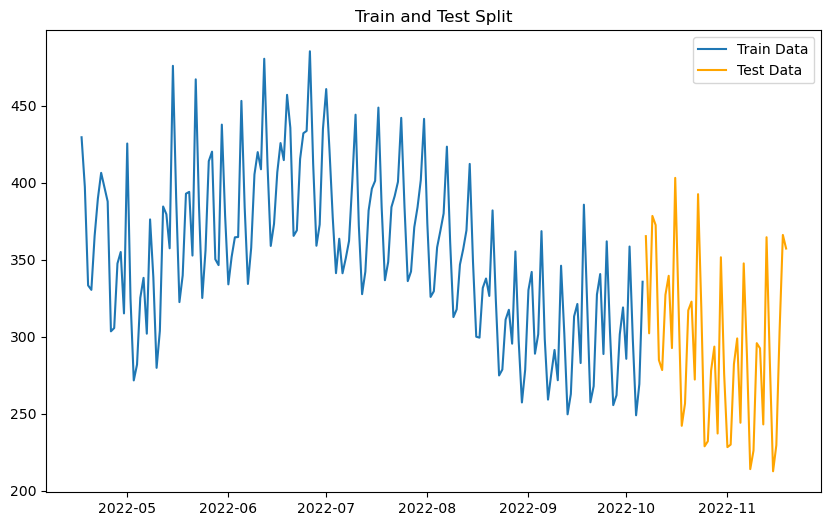

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting M

                               SARIMAX Results                                
Dep. Variable:              totalFare   No. Observations:                  172
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -860.859
Date:                Mon, 02 Dec 2024   AIC                           1731.717
Time:                        03:18:36   BIC                           1747.425
Sample:                             0   HQIC                          1738.091
                                - 172                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2369      0.276      0.858      0.391      -0.304       0.778
ar.L2         -0.3579      0.148     -2.415      0.016      -0.648      -0.067
ma.L1         -0.6964      0.269     -2.587      0.0

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


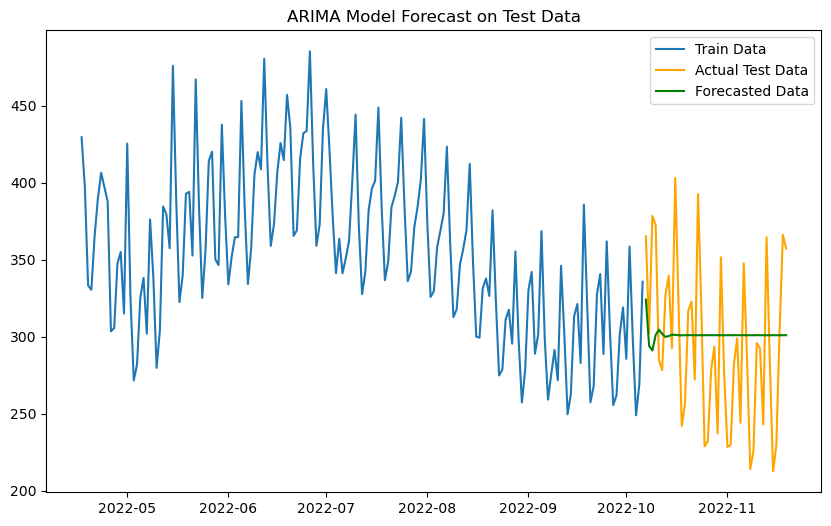

Model Performance on Test Data:
Root Mean Squared Error (RMSE): 52.1423735511614
Mean Absolute Error (MAE): 43.613875720277136
R-squared (R2): 1.0


In [38]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Split the train and test 
train_size = int(len(df_time_series_pandas) * 0.8) 
train_data = df_time_series_pandas['totalFare'][:train_size]
test_data = df_time_series_pandas['totalFare'][train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Test Data", color="orange")
plt.title("Train and Test Split")
plt.legend()
plt.show()

# Define the ARIMA model
p, d, q = 2, 1, 2  # Use the parameter we selected
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

# predict on the test data
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Actual Test Data", color="orange")
plt.plot(test_data.index, forecast, label="Forecasted Data", color="green")
plt.title("ARIMA Model Forecast on Test Data")
plt.legend()
plt.show()

# Model evaluation
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)
r2 = 1 - (np.sum((test_data - forecast)**2) / np.sum((test_data - np.mean(test_data))**2))

print(f"Model Performance on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Performance on Test data
rmse_arima = np.sqrt(mean_squared_error(test_data, forecast))
mae_arima = mean_absolute_error(test_data, forecast)
ss_res = np.sum((test_data - forecast) ** 2)
ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
r2_arima = 1 - (ss_res / ss_tot)

print("ARIMA Performance:")
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")
print(f"R-squared: {r2_arima}")

ARIMA Performance:
RMSE: 52.04561788154634
MAE: 43.433610186595985
R-squared: -0.0035340445617835226


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA Model
seasonal_order = (1, 1, 1, 7)  # Assuming One week as a season
sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

# Test
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

plt.figure(figsize=(10, 6))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Actual Test Data", color="orange")
plt.plot(test_data.index, sarima_forecast, label="SARIMA Forecast", color="green")
plt.title("SARIMA Model Forecast on Test Data")
plt.legend()
plt.show()